In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [26]:
start_date = "2025-01-03"
today = datetime.date.today()

In [27]:
gold = yf.download("GC=F", start=start_date, end=today)
silver = yf.download("SI=F", start=start_date, end=today)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [28]:
data = pd.concat([gold['Close'],silver['Close']],axis=1)
data.columns = ["Gold_Close", "Silver_Close"]

In [29]:
data

,Gold_Close,Silver_Close
Date,,
2025-01-03,2645.000000,29.806000
2025-01-06,2638.399902,30.341999
2025-01-07,2656.699951,30.447001
2025-01-08,2664.500000,30.452000
2025-01-09,2683.800049,30.791000
...,...,...
2025-07-21,3401.899902,39.101002
2025-07-22,3439.199951,39.320000
2025-07-23,3394.100098,39.278000


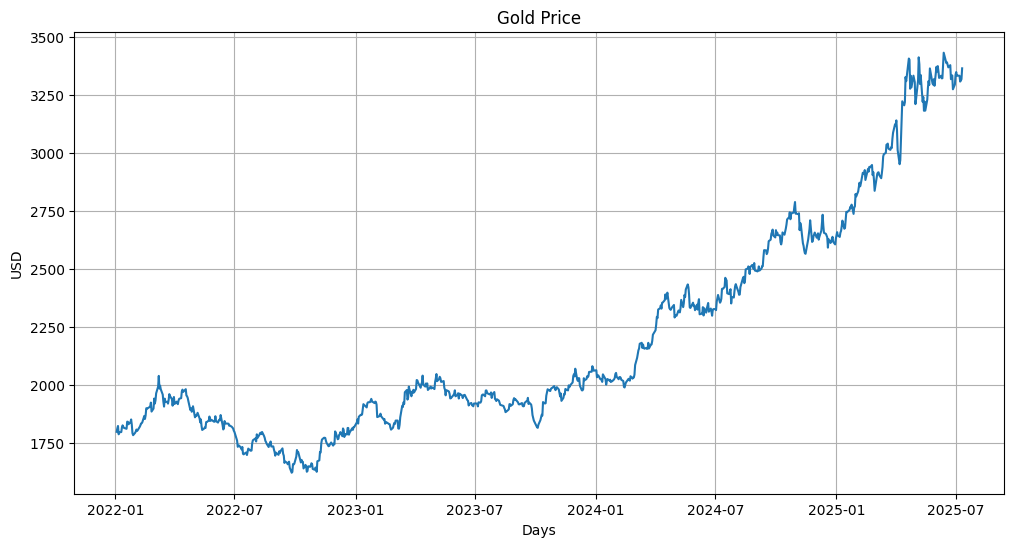

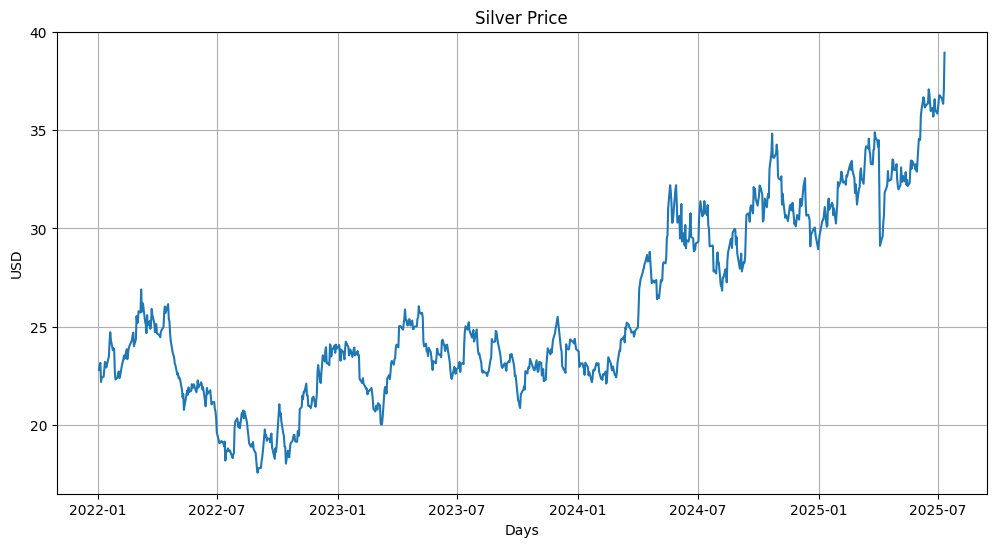

In [5]:
plt.figure(figsize=(12,6))
plt.plot(data["Gold_Close"])
plt.grid(True)
plt.title("Gold Price")
plt.xlabel("Days")
plt.ylabel("USD")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(data["Silver_Close"])
plt.grid(True)
plt.title("Silver Price")
plt.xlabel("Days")
plt.ylabel("USD")
plt.show()

In [6]:
data = data.dropna()

corr = data["Gold_Close"].corr(data["Silver_Close"])
print(f"The correlation between gold and silver is: {corr}")

The correlation between gold and silver is: 0.9446547928209176


In [7]:
slope, intercept, r_value, p_value, std_error = stats.linregress(
    data["Gold_Close"], data["Silver_Close"]
)

X = data["Gold_Close"].values.reshape(-1, 1)
y = data["Silver_Close"].values

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [8]:
# From sklearn

print("Slope (coef_):", model.coef_[0])
print("Intercept (intercept_):", model.intercept_)
print("R^2 score:", model.score(X, y))

# From scipy

print("Slope (coef_):", slope)
print("Intercept (intercept_):", intercept)
print("R^2 score:", r_value**2)

Slope (coef_): 0.009408004508551683
Intercept (intercept_): 5.079623810732244
R^2 score: 0.8923726775995295
Slope (coef_): 0.009408004508551695
Intercept (intercept_): 5.079623810732215
R^2 score: 0.8923726775995303


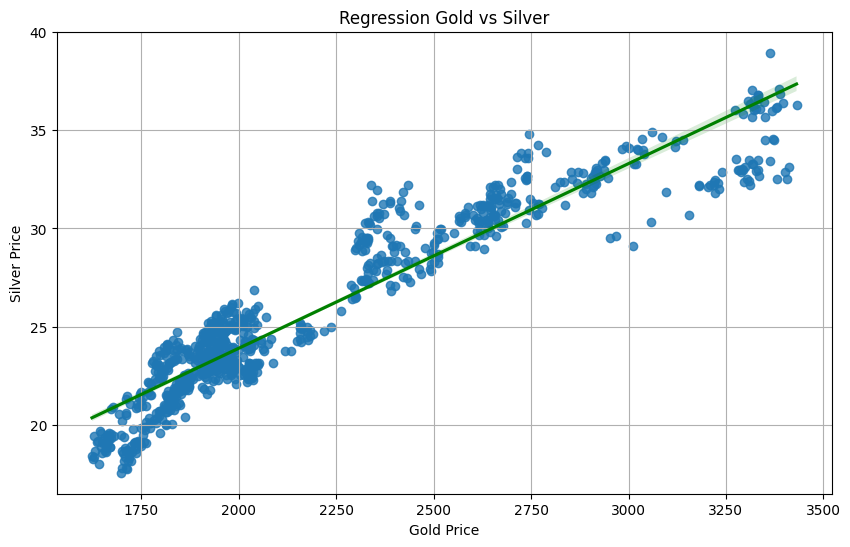

In [9]:
plt.figure(figsize=(10,6))
sns.regplot(x="Gold_Close", y="Silver_Close", data=data, line_kws={"color": "green"})
plt.title("Regression Gold vs Silver")
plt.xlabel("Gold Price")
plt.ylabel("Silver Price")
plt.grid(True)
plt.show()

In [10]:
data['Silver_Predicted'] = slope * data['Gold_Close'] + intercept
data['Residual'] = data['Silver_Close'] - data['Silver_Predicted']

In [11]:
data.head()

,Gold_Close,Silver_Close,Silver_Predicted,Residual
Date,,,,
2022-01-03,1799.400024,22.790001,22.008387,0.781614
2022-01-04,1814.000000,23.038000,22.145744,0.892256
2022-01-05,1824.599976,23.150000,22.245469,0.904531
2022-01-06,1788.699951,22.174000,21.907721,0.266279
2022-01-07,1797.000000,22.393999,21.985808,0.408191


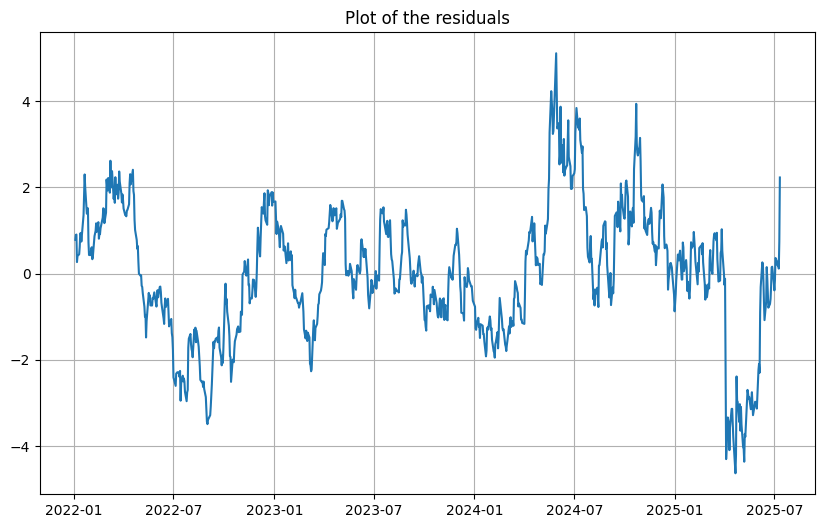

In [12]:
plt.figure(figsize=(10,6))
plt.title("Plot of the residuals")
plt.plot(data["Residual"])
plt.grid(True)
plt.show()

In [13]:
# Trading strategy

threshold = data["Residual"].std()

data['Signal'] = 0
data.loc[data['Residual'] > threshold, 'Signal'] = -1  # short silver, long gold
data.loc[data['Residual'] < -threshold, 'Signal'] = 1  # long silver, short gold

data

,Gold_Close,Silver_Close,Silver_Predicted,Residual,Signal
Date,,,,,
2022-01-03,1799.400024,22.790001,22.008387,0.781614,0
2022-01-04,1814.000000,23.038000,22.145744,0.892256,0
2022-01-05,1824.599976,23.150000,22.245469,0.904531,0
2022-01-06,1788.699951,22.174000,21.907721,0.266279,0
2022-01-07,1797.000000,22.393999,21.985808,0.408191,0
...,...,...,...,...,...
2025-07-07,3332.199951,36.615002,36.428976,0.186026,0
2025-07-08,3307.000000,36.472000,36.191895,0.280105,0
2025-07-09,3311.600098,36.351002,36.235172,0.115829,0


In [14]:
total_days = len(data["Signal"])
total_signals = sum(abs(s) for s in data["Signal"])
pct_signals = total_signals / total_days
print(f"Signal present {pct_signals*100}% of the times")

Signal present 27.90960451977401% of the times


In [15]:
data['Position'] = 0
position = 0

for i in range(1, len(data)):
    if data["Signal"].iloc[i] != 0:
        position = data["Signal"].iloc[i]
    elif position != 0 and np.sign(data['Residual'].iloc[i-1]) != np.sign(data['Residual'].iloc[i]):
        """Exit position if the residuals change sign"""
        position = 0  # exit
    data.iloc[i, data.columns.get_loc('Position')] = position


In [16]:
data.head()

,Gold_Close,Silver_Close,Silver_Predicted,Residual,Signal,Position
Date,,,,,,
2022-01-03,1799.400024,22.790001,22.008387,0.781614,0,0
2022-01-04,1814.000000,23.038000,22.145744,0.892256,0,0
2022-01-05,1824.599976,23.150000,22.245469,0.904531,0,0
2022-01-06,1788.699951,22.174000,21.907721,0.266279,0,0
2022-01-07,1797.000000,22.393999,21.985808,0.408191,0,0


In [17]:
data['Silver_Return'] = data['Silver_Close'].pct_change()
data['Gold_Return'] = data['Gold_Close'].pct_change()
data.head()

,Gold_Close,Silver_Close,Silver_Predicted,Residual,Signal,Position,Silver_Return,Gold_Return
Date,,,,,,,,
2022-01-03,1799.400024,22.790001,22.008387,0.781614,0,0,NaN,NaN
2022-01-04,1814.000000,23.038000,22.145744,0.892256,0,0,0.010882,0.008114
2022-01-05,1824.599976,23.150000,22.245469,0.904531,0,0,0.004862,0.005843
2022-01-06,1788.699951,22.174000,21.907721,0.266279,0,0,-0.042160,-0.019676
2022-01-07,1797.000000,22.393999,21.985808,0.408191,0,0,0.009921,0.004640


In [18]:
# This strategy assumes we buy the same amount of silver and gold

data['Strategy_Return'] = data['Position'].shift(1) * (data['Silver_Return'] - data['Gold_Return'])

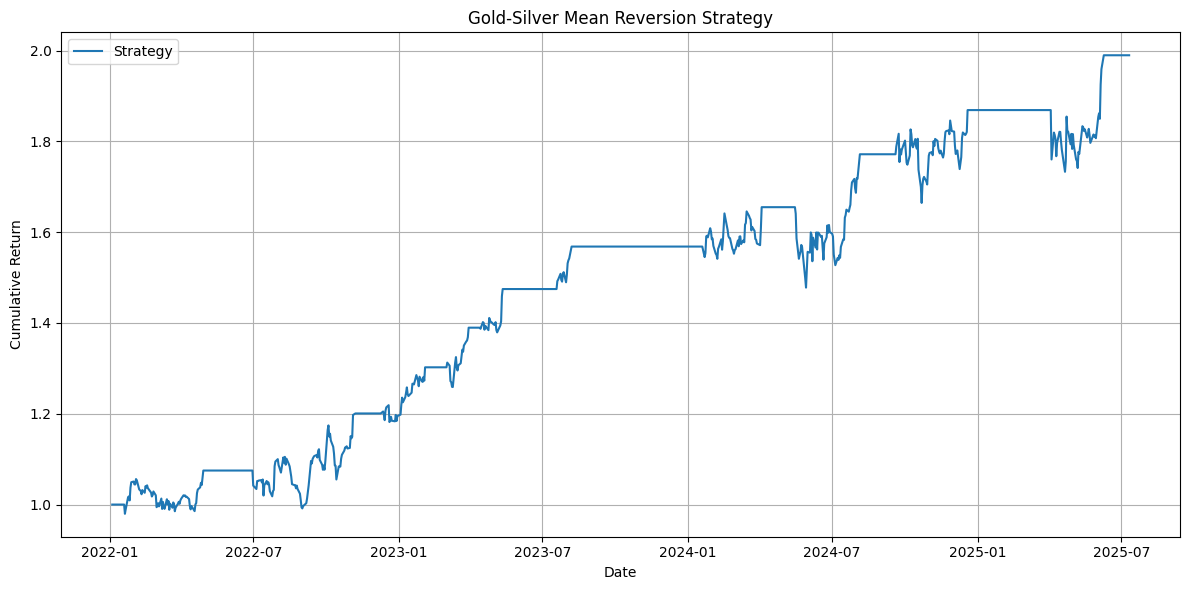

In [19]:
data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Return'], label='Strategy')
plt.title("Gold-Silver Mean Reversion Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from utils.portfolio_evaluation import sharpe_ratio

In [21]:
returns = data['Strategy_Return'].dropna().to_numpy()
rf_daily = 0.04 / 252
sharpe = sharpe_ratio(returns, dt=252, rf=rf_daily)
print(f"The Sharpe Ratio of our strategy is: {sharpe}")

The Sharpe Ratio of our strategy is: 1.019368552999773


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns

def get_data(start_date, end_date):

    gold = yf.download("GC=F", start=start_date, end=end_date)
    silver = yf.download("SI=F", start=start_date, end=end_date)

    data = pd.concat([gold['Close'],silver['Close']],axis=1)
    data.columns = ["Gold_Close", "Silver_Close"]

    data = data.dropna()

    return data

def get_linear_regression(data):

    corr = data["Gold_Close"].corr(data["Silver_Close"])

    slope, intercept, r_value, p_value, std_error = stats.linregress(
        data["Gold_Close"], data["Silver_Close"]
    )

    return corr, slope, intercept, r_value, p_value, std_error

def get_predictions(data, slope, intercept):

    data['Silver_Predicted'] = slope * data['Gold_Close'] + intercept
    data['Residual'] = data['Silver_Close'] - data['Silver_Predicted']

    return data

# Trading strategy

def get_treshold(data):

    threshold = data["Residual"].std()

    data['Signal'] = 0
    data.loc[data['Residual'] > threshold, 'Signal'] = -1  # short silver, long gold
    data.loc[data['Residual'] < -threshold, 'Signal'] = 1  # long silver, short gold

def run_strategy(data):
    data['Position'] = 0
    position = 0

    for i in range(1, len(data)):
        if data["Signal"].iloc[i] != 0:
            position = data["Signal"].iloc[i]
        elif position != 0 and np.sign(data['Residual'].iloc[i-1]) != np.sign(data['Residual'].iloc[i]):
            """Exit position if the residuals change sign"""
            position = 0  # exit
        data.iloc[i, data.columns.get_loc('Position')] = position

    data['Silver_Return'] = data['Silver_Close'].pct_change()
    data['Gold_Return'] = data['Gold_Close'].pct_change()


    data['Strategy_Return'] = data['Position'].shift(1) * (data['Silver_Return'] - data['Gold_Return'])

    data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()

    return data

if __name__ == "__main__":
    start_date = "2000-01-01"
    end_date = datetime.date.today()

    data = get_data(start_date=start_date, end_date=end_date)

    


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
len(data)

6247

In [ ]:
import numpy as np

list_n = np.arange(0, 1.0, 0.25)
list_b = np.arange(0, 0.5, 0.01)
final = np.concatenate([list_n, list_b])
max_index = np.max

array([0.  , 0.25, 0.5 , 0.75, 0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
       0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17,
       0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28,
       0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39,
       0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49])

In [31]:
import yfinance as yf
import pandas as pd

# Download data
gold = yf.download("GC=F", start="1999-01-01", progress=False)
silver = yf.download("SI=F", start="1999-01-01", progress=False)

# Convert index to datetime
gold.index = pd.to_datetime(gold.index)
silver.index = pd.to_datetime(silver.index)

# Count trading days per year
gold_days_per_year = gold.groupby(gold.index.year).size()
silver_days_per_year = silver.groupby(silver.index.year).size()

# Combine and display
trading_days = pd.DataFrame({
    "Gold": gold_days_per_year,
    "Silver": silver_days_per_year
})

print(trading_days)


      Gold  Silver
Date              
2000    84      84
2001   247     248
2002   250     250
2003   250     250
2004   249     249
2005   248     248
2006   250     251
2007   252     252
2008   253     253
2009   252     252
2010   252     252
2011   252     252
2012   250     250
2013   252     252
2014   252     252
2015   252     252
2016   250     250
2017   251     251
2018   250     250
2019   252     252
2020   253     253
2021   252     252
2022   251     251
2023   250     250
2024   252     252
2025   143     143


### Limitations

In real life, we do not get to build a linear regression model with future data, how would you address that?
